# Step 0: Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scipy.stats import beta

# Step 1: Get the prior data from before

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [3]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 0.4
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [4]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [5]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

In [6]:
def transform_values(i,n,prior=1/2):
    return (i*(n-1)+prior)/n

In [7]:
prior_a, prior_b, loc, scale = beta.fit([transform_values(i, len(train_videos.values),1/2)
                                          for i in train_videos.values], floc=0, fscale=1)

In [8]:
prior_a *= 10
prior_b *= 10
print(prior_a, prior_b)

14.270965891341989 5.916156493565227


# Step 2: Load in the kuairec test dataset in case we need it

In [9]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.rename(columns={'liked_x': 'liked', 'liked_y': 'like_ratio'})

In [10]:
num_samples = 100

In [11]:
sampled_videos = (list(test_videos.sample(num_samples, random_state=1729).keys()))

In [12]:
kuairec_chosen = kuairec_test[kuairec_test['video_id'].isin(sampled_videos)]

In [13]:
videos_of_interest = video_df[sampled_videos].sort_values()
videos_of_interest = list(videos_of_interest.iloc[[0, num_samples//4, 2*num_samples//4, 3*num_samples//4, -2, -1]].keys())
videos_of_interest

[9136, 9885, 6172, 7257, 2687, 7076]

In [14]:
indices_of_interest = [sampled_videos.index(item) for item in videos_of_interest]

# Step 3: Load in simulation data

In [15]:
data_dict = dict()
for val in [0.0, 0.3, 0.7, 1.0]:
    data_dict[val] = np.load(f'soal_sims/sim_data_alpha_{val}.npy',allow_pickle=True)[()]

In [16]:
data_dict[0.0].keys()

dict_keys([10328, 1351, 6757, 1095, 4028, 8915, 4706, 4443, 7039, 6763, 1299, 7227, 8475, 6259, 8359, 6293, 4158, 4685, 9736, 3191, 4659, 2365, 10257, 701, 2475, 10462, 5596, 5448, 7226, 4556, 2559, 2578, 7695, 7293, 3064, 3970, 9177, 2029, 2503, 9149, 632, 6788, 937, 4571, 8681, 4041, 5731, 5690, 8736, 3125, 4451, 1170, 423, 2045, 5326, 4131, 9882, 3118, 5612, 9682, 4076, 1439, 589, 1212, 4188, 1386, 7014, 2573, 579, 5535, 3866, 5838, 845, 2575, 9995, 9925, 9102, 5876, 5813, 983, 5537, 8162, 1452, 8629, 10078, 10589, 7109, 7526, 9898, 5865, 2521, 542, 9947, 1126, 4145, 9571, 4554, 6251, 4632, 3082])

In [19]:
data_dict[0.3].keys()

dict_keys([(10328, 0.3), (1351, 0.3), (6757, 0.3), (1095, 0.3), (4028, 0.3), (8915, 0.3), (4706, 0.3), (4443, 0.3), (7039, 0.3), (6763, 0.3), (1299, 0.3), (7227, 0.3), (8475, 0.3), (6259, 0.3), (8359, 0.3), (6293, 0.3), (4158, 0.3), (4685, 0.3), (9736, 0.3), (3191, 0.3), (4659, 0.3), (2365, 0.3), (10257, 0.3), (701, 0.3), (2475, 0.3), (10462, 0.3), (5596, 0.3), (5448, 0.3), (7226, 0.3), (4556, 0.3), (2559, 0.3), (2578, 0.3), (7695, 0.3), (7293, 0.3), (3064, 0.3), (3970, 0.3), (9177, 0.3), (2029, 0.3), (2503, 0.3), (9149, 0.3), (632, 0.3), (6788, 0.3), (937, 0.3), (4571, 0.3), (8681, 0.3), (4041, 0.3), (5731, 0.3), (5690, 0.3), (8736, 0.3), (3125, 0.3), (4451, 0.3), (1170, 0.3), (423, 0.3), (2045, 0.3), (5326, 0.3), (4131, 0.3), (9882, 0.3), (3118, 0.3), (5612, 0.3), (9682, 0.3), (4076, 0.3), (1439, 0.3), (589, 0.3), (1212, 0.3), (4188, 0.3), (1386, 0.3), (7014, 0.3), (2573, 0.3), (579, 0.3), (5535, 0.3), (3866, 0.3), (5838, 0.3), (845, 0.3), (2575, 0.3), (9995, 0.3), (9925, 0.3), (9102

# Step 4: Plotting time

## Step 4.1: Sanity checking

### Step 4.1.1 ensure all eb priors are consistent

In [24]:
for k in data_dict:
    if not type(k) == float:
        k = k[0]
    curr_priors = ((1-k)*1.0 + k*prior_a, (1-k)*1.0 + k*prior_b)
    for j in data_dict[k]:
        for arr in data_dict[k][j]:
            if np.round(arr[0,0],5) != np.round(curr_priors[0],5) or np.round(arr[0,1],5) != np.round(curr_priors[1],5):
                print(arr[0])
                print(curr_priors)
                assert False

### Step 4.1.2 ensure that data overwhelms the prior

In [57]:
np.unique(data_dict[0.0][10328][0],axis=0)

array([[1., 1.],
       [2., 1.],
       [3., 1.],
       [4., 1.],
       [5., 1.],
       [6., 1.],
       [7., 1.],
       [8., 1.],
       [9., 1.],
       [9., 2.],
       [9., 3.]])

In [71]:
num_quints = 5
cutoff = 80
quantile_df = pd.qcut(video_df,q=num_quints,labels=[1,2,3,4,5])

In [72]:
plot_dict = dict()
count_dict = dict()
for k in data_dict:
    curr_priors = ((1-k)*1.0 + k*prior_a, (1-k)*1.0 + k*prior_b)
    for quint in range(1,num_quints+1):
        plot_dict[(k, quint)] = np.zeros(cutoff)
        count_dict[(k, quint)] = 0
    for l in data_dict[k]:
        for traj in data_dict[k][l]:
            t = np.unique(traj,axis=0)
            if len(t) >= cutoff:
                prod_id = l if k==0.0 else l[0]
                traj_qual = quantile_df[prod_id]
                plot_dict[(k, traj_qual)] += t[:cutoff,0]/(t[:cutoff,0] + t[:cutoff,1])
                count_dict[(k, traj_qual)] += 1

for k in count_dict:
    if count_dict[k] != 0:
        plot_dict[k] = plot_dict[k]/count_dict[k]

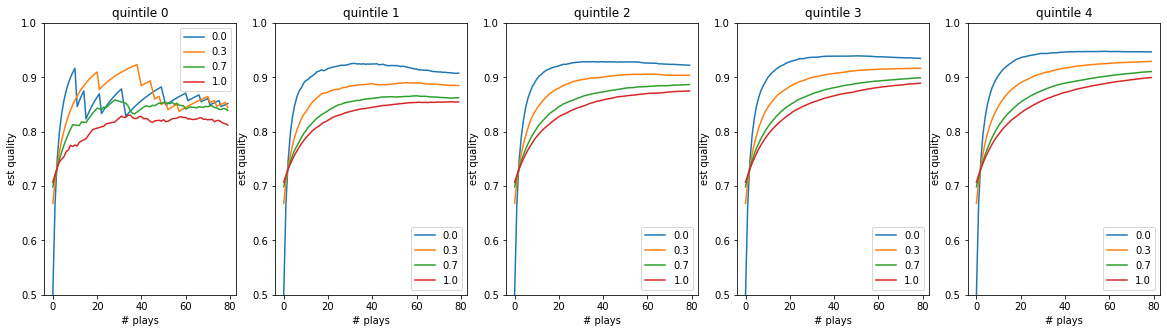

In [78]:
f,axes=plt.subplots(1,5)
f.set_size_inches(20, 5)
for i in range(len(axes)):
    plt.sca(axes[i])
    plt.title(f'quintile {i}')
    plt.ylim((0.5, 1))
    keys = [(k,i+1) for k in data_dict]
    for k in keys:
        plt.plot(plot_dict[k],label=k[0])
    plt.legend()
    plt.xlabel('# plays')
    plt.ylabel('est quality')

In [81]:
plot_dict = dict()
count_dict = dict()
for k in data_dict:
    curr_priors = ((1-k)*1.0 + k*prior_a, (1-k)*1.0 + k*prior_b)
    count_dict[k] = 0
    plot_dict[k] = np.zeros(cutoff)
    for l in data_dict[k]:
        for traj in data_dict[k][l]:
            t = np.unique(traj,axis=0)
            if len(t) >= cutoff:
                plot_dict[k] += t[:cutoff,0]/(t[:cutoff,0] + t[:cutoff,1])
                count_dict[k] += 1

for k in count_dict:
    if count_dict[k] != 0:
        plot_dict[k] = plot_dict[k]/count_dict[k]

Text(0, 0.5, 'est quality')

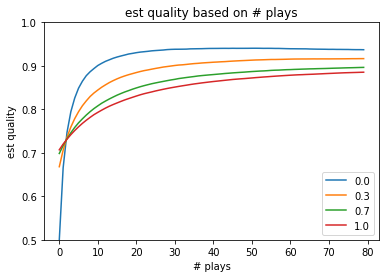

In [84]:
plt.ylim((0.5, 1))
keys = [k for k in data_dict]
for k in keys:
    plt.plot(plot_dict[k],label=k)
plt.legend()
plt.title('est quality based on # plays')
plt.xlabel('# plays')
plt.ylabel('est quality')

## Step 4.2 - how impactful is early performance on later plays?

In [146]:
num_quants = 10
cutoff = 100 # must be greater than or equal to 10

In [147]:
# build the modified data dict from the existing data dict

quantile_df = pd.qcut(video_df,q=num_quants,labels=range(1,num_quants+1))
modified_data_dict = dict()
for k in data_dict:
    d = dict()
    for l in data_dict[k]:
        for traj in data_dict[k][l]:
            if traj.shape[0] >= cutoff + 1:
                prod_id = l if k==0.0 else l[0]
                traj_qual = quantile_df[prod_id] # get quality to closest multiple of 0.2
                truncated_traj = copy.deepcopy(traj)[cutoff,:]
                num_likes_at_10 = int(np.sum(traj[10,0]) - np.sum(traj[0,0]))
                num_likes_at_10 = 3 if num_likes_at_10 > 3 else num_likes_at_10
                truncated_traj = np.sum(truncated_traj) - np.sum(traj[0,:])
                if (num_likes_at_10, traj_qual) in d:
                    d[(num_likes_at_10, traj_qual)].append(truncated_traj)
                else:
                    d[(num_likes_at_10,traj_qual)] = [truncated_traj]
                
    modified_data_dict[k] = d

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


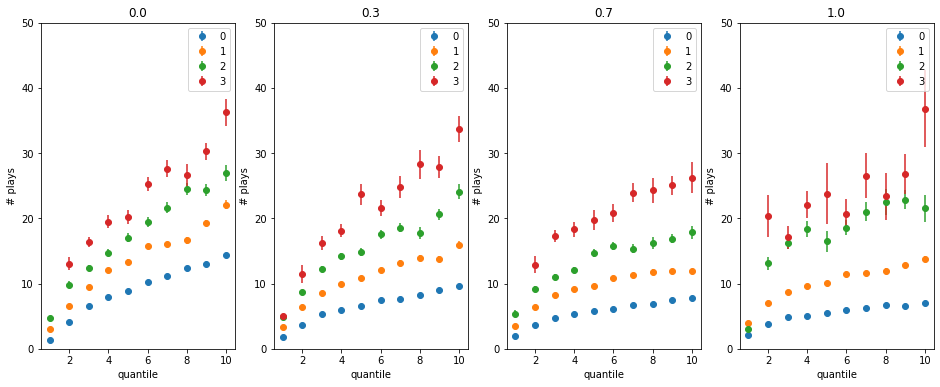

In [148]:
f, axes = plt.subplots(1,4)
f.set_size_inches(16,6)
prior_keys = sorted(list(modified_data_dict.keys()))
# f.suptitle('number of plays conditioned on # of likes in first 10 timesteps',y=0.91)
for i in range(len(axes)):
    plt.sca(axes[i])
    k = prior_keys[i]
    curr_dict = modified_data_dict[k]
    for num_likes in np.unique([a for (a,b) in modified_data_dict[k].keys()]):
#         plt.scatter(x=[b for (a,b) in modified_data_dict[k].keys() if a==num_likes],
#                     y=[np.mean(modified_data_dict[k][(num_likes,b)]) for (a,b) in modified_data_dict[k].keys() if a==num_likes],
#                     label=num_likes)
        plt.errorbar(x=[b for (a,b) in modified_data_dict[k].keys() if a==num_likes],
            y=[np.mean(modified_data_dict[k][(num_likes,b)]) for (a,b) in modified_data_dict[k].keys() if a==num_likes],
            yerr =[scipy.stats.sem(modified_data_dict[k][(num_likes,b)]) for (a,b) in modified_data_dict[k].keys() if a==num_likes],
            fmt='o',
            label=num_likes)
    plt.legend()
    plt.title(k)
    plt.ylim((0,50))
    plt.xlabel('quantile')
    plt.ylabel('# plays')
        

## Step 4.3 - true quality vs. number of plays

In [150]:
quantile_df = pd.cut(video_df, np.linspace(0,1,21), labels=(np.linspace(0,0.95,20) + np.linspace(0.05, 1,20))/2)
cutoff = 60

In [151]:
for k in data_dict:
    d = dict()
    for l in data_dict[k]:
        for traj in data_dict[k][l]:
            if traj.shape[0] >= cutoff + 1:
                prod_id = l if k==0.0 else l[0]
                traj_qual = quantile_df[prod_id] # get quality to closest multiple of 0.2
                truncated_traj = copy.deepcopy(traj)[cutoff,:]
                truncated_traj = np.sum(truncated_traj) - np.sum(traj[0,:])
                if traj_qual in d:
                    d[traj_qual].append(truncated_traj)
                else:
                    d[traj_qual] = [truncated_traj]
                
    modified_data_dict[k] = d

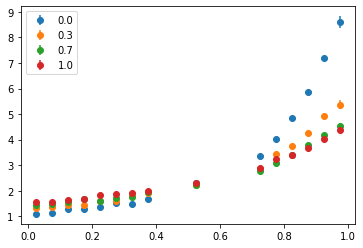

In [155]:
for k in modified_data_dict.keys():
    plt.errorbar(x=list(modified_data_dict[k].keys()),
                 y=[np.mean(modified_data_dict[k][l]) for l in modified_data_dict[k].keys()],
                 yerr=[scipy.stats.sem(modified_data_dict[k][l]) for l in modified_data_dict[k].keys()], # plot std errorbars here!
                 fmt='o',
                 label=k)
    plt.legend()